# Glucose Insulin Metabolism Model by Sorensen (1985).

In this notebook, the model of glucose and insulin metabolism, from the thesis of Thomas
J. Sorensen, 1985 [[1]](#References), is used as an example of how the `yaml2sbml.YamlModel` class can be used to easily extend a pre-existing `yaml2sbml`
model.

Specifically, the model is edited to reproduce a figure from the original
thesis (Fig 71) [[1]](#References). The implementation that is loaded here is based on the implementation
provided by Panunzi et al., 2020 [[2]](#References). 

In the end, the model is exported to [SBML](http://sbml.org/) and simulated via [AMICI](https://github.com/AMICI-dev/AMICI).

## Extend the current YAML model

The Sorensen model has already been encoded in the YAML format. Within this notebook, the model is loaded, extended in order to model an intravenous infusion administration of glucose, using the `yaml2sbml` Model editor. The extended model is then plotted, to reproduce a figure from Sorensens PhD thesis.

### Load the model

In [1]:
import yaml2sbml
from yaml2sbml import YamlModel

yaml_model = YamlModel.load_from_yaml('Sorensen1985.yaml')

### Define the glucose infusion term

An intravenous infusion administration of glucose is added to the model. After 17 minutes of initialization, glucose is infused at a rate of 64.81 mM/min for a three-minute period.

In the YAML model, this is represented by a novel term `IVG` ("intravenous glucose"), that is set by a step function in an assignment rule.

In [2]:
# describe the intravenous glucose infusion
yaml_model.add_assignment('IVG', formula='piecewise(64.81, 17 <= t && t < 20, 0)')

### Add the glucose infustion term to the model

`IVG` is now added to the ODE of the glucose concentration of heart and lung space `GlucH`. Therefore, the current ODE is overwritten.

In [3]:
# Get the current ODE.
gluch_ode_old = yaml_model.get_ode_by_id('GlucH')
gluch_rhs_old = gluch_ode_old['rightHandSide']

# Modify the ODE. `IVG` is divided by the volume term `VolGH` to
# model concentration.
gluch_rhs_new = gluch_rhs_old + ' + (IVG / VolGH)'

# Set the new ODE.
yaml_model.add_ode(state_id='GlucH', 
                   right_hand_side=gluch_rhs_new, 
                   initial_value=gluch_ode_old['initialValue'], 
                   overwrite=True)

### Export to SBML

In [4]:
# Write to SBML
yaml_model.write_to_sbml('Fig71_Sorensen1985.xml', overwrite=True)

## Simulation in AMICI

The model is now setup to reproduce to the figure. The utility function `simulate_and_plot_sorensen` simulates and plots the Sorensen model in [AMICI](https://github.com/AMICI-dev/AMICI).

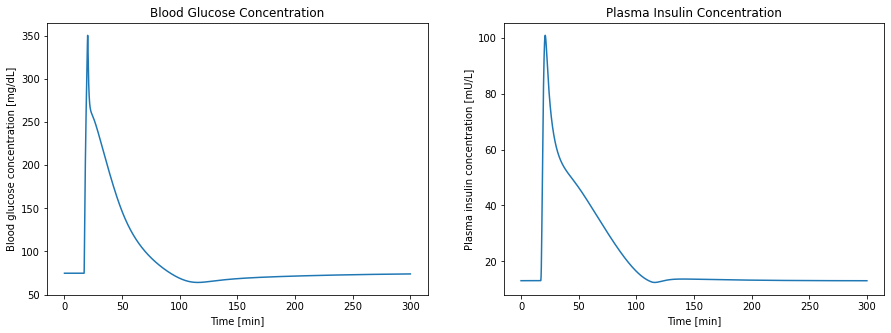

In [5]:
%matplotlib inline
from utils import simulate_and_plot_sorensen

simulate_and_plot_sorensen('Fig71_Sorensen1985.xml')

Trajectories are plotted, which closely match
the original thesis figures.

Note that this figure has a shift in the x-axis, as the simulation here
started at `time == 0`, but in the thesis started at approximately `time == -20`.
As there are no explicit time dependencies in the model, the figure is
otherwise similar.

# References

[1] Sorensen, J. T. (1985).
"A physiologic model of glucose metabolism in man and its use 
to design and assess improved insulin therapies for diabetes."
https://dspace.mit.edu/handle/1721.1/15234

[2] Panunzi, S., Pompa, M., Borri, A., Piemonte, V., & De Gaetano, A. (2020).
A revised Sorensen model: Simulating glycemic and insulinemic response to oral
and intra-venous glucose load. Plos one, 15(8), e0237215.
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0237215